In [1]:
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster('local').setAppName('restaurant-review-average')

In [3]:
spark = SparkContext(conf=conf).getOrCreate()

24/12/03 14:29:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
# 나중에 항상 stop은 챙기기
# spark.stop()

In [5]:
import os

In [72]:
#directory = ''
directory = os.path.join(os.getcwd(), 'data')
file_name = 'restaurant_reviews.csv'
file_path = os.path.join(directory, file_name)

In [73]:
lines = spark.textFile('file:///' + file_path.replace('\\','/'))
lines

file:////home/lab17/git/src/data/restaurant_reviews.csv MapPartitionsRDD[72] at textFile at NativeMethodAccessorImpl.java:0

In [81]:
lines.take(5)

['id,item,cateogry,reviews,',
 '0,짜장면,중식,125,',
 '1,짬뽕,중식,235,',
 '2,김밥,분식,32,',
 '3,떡볶이,분식,534,']

In [82]:
header = lines.first()
header

'id,item,cateogry,reviews,'

In [83]:
datas = lines.filter(lambda r : r != header)
datas

PythonRDD[81] at RDD at PythonRDD.scala:53

In [27]:
index_file = datas.map(lambda r: r.split(',')[0])

index_file.collect()[:2]
index_file.countByValue()

defaultdict(int,
            {'0': 1,
             '1': 1,
             '2': 1,
             '3': 1,
             '4': 1,
             '5': 1,
             '6': 1,
             '7': 1,
             '8': 1,
             '9': 1})

In [89]:
datas.take(5)

['0,짜장면,중식,125,',
 '1,짬뽕,중식,235,',
 '2,김밥,분식,32,',
 '3,떡볶이,분식,534,',
 '4,라멘,일식,223,']

### 수업 내용

In [29]:
def parse(row):
    fields = row.split(',')
    category = fields[2]
    reviews = int(fields[3])
    
    return category, reviews

In [84]:
parse('0,짜장면,중식,125,')

('중식', 125)

### RDD 내 모든 row에 대해서 parse()를 적용 + map() 추출
  
기본적으로는 RDD로 하지만, 2개의 컬럼을 가지는 데이터 형식으로 처리하곤함(KVRDD)  
  
KVRDD = Key-Value RDD

In [91]:
category_reviews = datas.map(parse)
category_reviews.take(5)

[('중식', 125), ('중식', 235), ('분식', 32), ('분식', 534), ('일식', 223)]

In [92]:
category_reviews.countByValue()

defaultdict(int,
            {('중식', 125): 1,
             ('중식', 235): 1,
             ('분식', 32): 1,
             ('분식', 534): 1,
             ('일식', 223): 1,
             ('일식', 52): 1,
             ('일식', 12): 1,
             ('아시안', 312): 1,
             ('패스트푸드', 12): 1,
             ('패스트푸드', 23): 15})

In [94]:
category_review_count = category_reviews.mapValues(lambda x : (x, 1))
category_review_count.take(3)

[('중식', (125, 1)), ('중식', (235, 1)), ('분식', (32, 1))]

'중식' (125,1)    
첫번째 중식 > (125,1) > x  
두번째 중식 > (235,1) > y  
리뷰의 개수의 합 = x[0] + y[0] = 360  
건수의 합 = x[1] + y[1]  
  
라는 로직을 진행할거임

In [95]:
#카테고리별 합계를 구하기
#reduce = 합계를 구함
reduce_rdd = category_review_count.reduceByKey(lambda x, y : (x[0]+y[0], x[1]+y[1]))
reduce_rdd.take(3)

[('중식', (360, 2)), ('분식', (566, 2)), ('일식', (287, 3))]

In [96]:
#전체 보기
reduce_rdd.collect()

[('중식', (360, 2)),
 ('분식', (566, 2)),
 ('일식', (287, 3)),
 ('아시안', (312, 1)),
 ('패스트푸드', (357, 16))]

In [97]:
# 평균구하기
average = reduce_rdd.mapValues(lambda x : x[0] / x[1])
average.take(3)

[('중식', 180.0),
 ('분식', 283.0),
 ('일식', 95.66666666666667),
 ('아시안', 312.0),
 ('패스트푸드', 22.3125)]

In [62]:
average.collect()

[('중식', 180.0),
 ('분식', 283.0),
 ('일식', 95.66666666666667),
 ('아시안', 312.0),
 ('패스트푸드', 17.5)]

# 데이터 추가해서 메뉴별 합계와 평균을 구하기

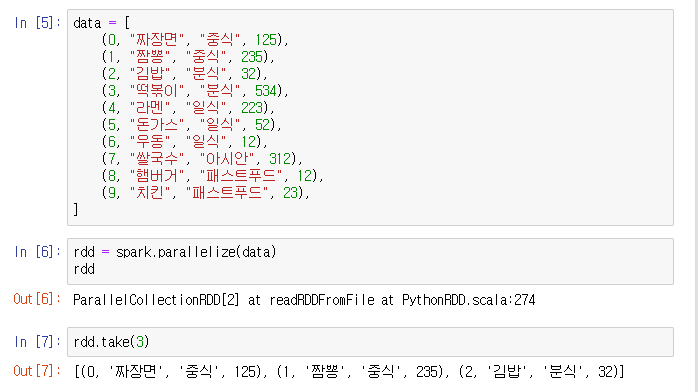

### 그냥 csv에 값을 추가해서 data 정의부터 다시 돌림